## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [ ]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [ ]:
# your code here
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
np.random.seed(1)

In [ ]:
Data1['logarithm_base10'] = np.log10(Data1['AvgDailyTrafficCount'])
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,logarithm_base10
0,-80.278366,40.468606,84.0,1.924279
1,-80.162117,40.384598,95.0,1.977724
2,-80.221205,40.366778,97.0,1.986772
3,-80.142455,40.622084,111.0,2.045323
4,-80.131975,40.544915,125.0,2.096910


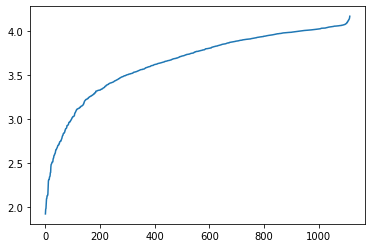

In [ ]:
plt.plot(Data1.logarithm_base10)
plt.show()

In [ ]:
X = np.asarray(Data1[['Longitude','Latitude']])
y = np.asarray(Data1.logarithm_base10)


In [ ]:
# 1），2）
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
k1 = 100 * RBF(length_scale=(1e-3, 1e3))  # long term smooth rising trend
#k2 = 100 * RBF(length_scale=100.0) \
   # * ExpSineSquared(length_scale=100.0, periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
#k3 = 100 * RationalQuadratic(length_scale=10.0)
k4 = 100 * RBF(length_scale=1)
k5 = WhiteKernel(noise_level=1.0,
                  noise_level_bounds=(1e-3, 1e3))  # noise terms
kernel = k1 + k4 + k5
gp = GaussianProcessRegressor(kernel=kernel,random_state=1)
gp.fit(X, y - y.mean())
y_mesh_pred, sigma = gp.predict(X, return_std=True)
print(gp.log_marginal_likelihood_value_)
print(gp.kernel_)

-435.46108603870493
0.0766**2 * RBF(length_scale=[174, 1e+03]) + 0.283**2 * RBF(length_scale=0.0353) + WhiteKernel(noise_level=0.107)


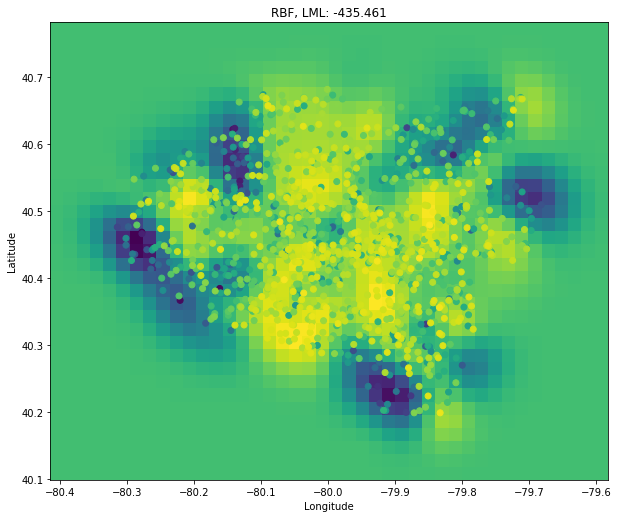

In [ ]:
# 3)
h = .02
x_min, x_max = Data1.Longitude.min() - 0.1, Data1.Longitude.max() + 0.1
y_min, y_max = Data1.Latitude.min() - 0.1, Data1.Latitude.max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")


plt.scatter(Data1.Longitude, Data1.Latitude, c=y)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood_value_))

plt.show()

In [ ]:
y_mesh_pred, sigma = gp.predict(X, return_std=True)
Data1['new_count'] = y - y.mean()
Data1['predict'] = y_mesh_pred
Data1['standard_deviation'] = sigma
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,logarithm_base10,predict,standard_deviation,new_count
0,-80.278366,40.468606,84.0,1.924279,-0.691837,0.345987,-1.727418
1,-80.162117,40.384598,95.0,1.977724,-0.348494,0.340960,-1.673973
2,-80.221205,40.366778,97.0,1.986772,-0.549450,0.361967,-1.664925
3,-80.142455,40.622084,111.0,2.045323,-0.548017,0.348225,-1.606374
4,-80.131975,40.544915,125.0,2.096910,-0.577459,0.339344,-1.554787


In [ ]:
# 4)
y_obs = y - y.mean()
count = 0
for i in range(len(y_obs)):
  if y_obs[i] > y_mesh_pred[i] + 2*sigma[i] or y_obs[i] < y_mesh_pred[i] - 2*sigma[i]:
    count += 1
print(count/len(y_obs))

0.04484304932735426


In [ ]:
label = []
for i in range(len(y_obs)):
  if y_obs[i] > y_mesh_pred[i] + 2*sigma[i] or y_obs[i] < y_mesh_pred[i] - 2*sigma[i]:
    label.append(0)
  else:
    label.append(1)


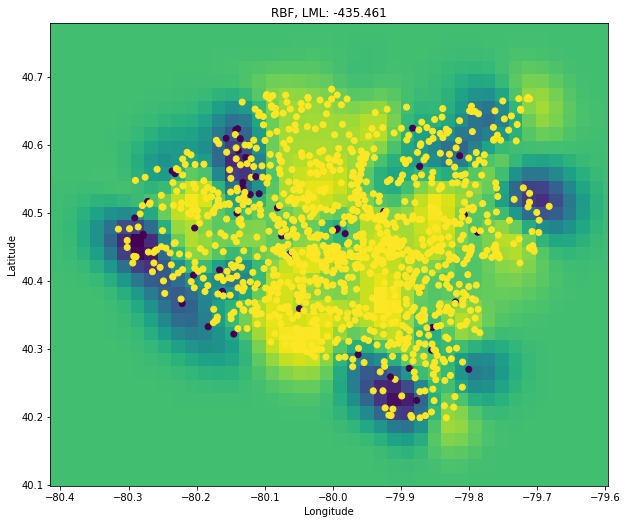

In [ ]:
plt.figure(figsize=(10, 10))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(Data1.Longitude, Data1.Latitude, c=[label])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood_value_))
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 200 points, center (15, 20), standard deviation 1

D: 2 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


### Your solutions here
(1,0) Anomaly. Even this is about 1 unit away from cluster A's center, cluster A has a standard deviation of 0.1, so 1 is about 10 standard deviation away from center, which is amost impossible belong to cluster A. 

(35,2) Not Anomaly. It is more near to center of cluster B, and it has a standard deviation of 5, the distance between this point and cluster center is less than 1 standard deviation. Therefore, it is very likely belong to cluster B. 

(15,19) Not Anomally. This point near to center of cluser C, which has a standard deviation of 1. The distance between two points is also 1, so it is one standard deviation away from this center, and can be likley belong to Cluster C.

(10,11) Anomaly. This point near to cluster D, but it only has two points in this cluser. Thus, both two pints in this cluster can be considered anomaly. 

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [ ]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [ ]:
Data2.columns

Index(['County', ''\% Reporting Fair/Poor Health'',
       ''Physically Unhealthy Days Per Month'',
       ''Mentally Unhealthy Days Per Month'', ''\% Low birth weight births'',
       ''\% Smokers'', ''\% Obese'', ''Food Environment Index'',
       ''\% Physically Inactive'', ''\% With Access To Exercise'',
       ''\% Excessive Drinking'', ''\% Alcohol-Impaired Driving Deaths'',
       ''Chlamydia Rate'', ''Teen Birth Rate'', ''\% Uninsured'',
       ''Preventable Hosp. Rate'', ''\% Dibetics receiving HbA1c'',
       ''\% Mammography'', ''Graduation Rate'', ''\% Some College'',
       ''\% Unemployed'', ''\% Children in Poverty'', ''80/20 Income Ratio'',
       ''\% Single-Parent Households'', ''Association Rate'',
       ''Violent Crime Rate'', ''Injury Death Rate'', ''Average Daily PM2.5'',
       ''\% Severe Housing Problems'', ''\% Drive Alone'',
       ''\% Long Commute - Drives Alone''],
      dtype='object')

In [ ]:
# your code here
# Part 1
df1 = Data2[['County',"'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]
df1.head()

,County,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,"Autauga, Alabama",19,31,254,4.3,18,12.9
1,"Baldwin, Alabama",19,27,221,4.5,20,13.1
2,"Barbour, Alabama",21,41,147,5.3,38,12.6
3,"Bibb, Alabama",21,40,236,4.3,27,12.9
4,"Blount, Alabama",19,32,219,4.1,24,12.7


In [ ]:
for i in df1.columns[1:]:
  df1 = df1[df1[i] != '?']
df1.head()

,County,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,"Autauga, Alabama",19,31,254,4.3,18,12.9
1,"Baldwin, Alabama",19,27,221,4.5,20,13.1
2,"Barbour, Alabama",21,41,147,5.3,38,12.6
3,"Bibb, Alabama",21,40,236,4.3,27,12.9
4,"Blount, Alabama",19,32,219,4.1,24,12.7


In [ ]:
for i,col in enumerate(df1.columns[1:]):
    df1.loc[:,col] = pd.to_numeric(pd.cut(df1[col].astype(np.float64),5,labels=np.arange(5)))
df_1 = df1.set_index(df1.columns[0])
df_1.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",1,2,0,1,1,3
"Baldwin, Alabama",1,2,0,1,1,3
"Barbour, Alabama",2,4,0,2,3,3
"Bibb, Alabama",2,4,0,1,2,3
"Blount, Alabama",1,2,0,1,1,3


In [ ]:
!pip install pgmpy


In [ ]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
# For other versions of pgmpy, move scoring_method parameter from initialization function to estimate function 
hc = HillClimbSearch(df_1)
best_model = hc.estimate(scoring_method=BicScore(df_1))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[("'\\% Smokers'", "'\\% Children in Poverty'"), ("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Obese'", "'\\% Smokers'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'")]


In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(df_1, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of '\% Smokers':
+-----------------+---------------+-----+---------------------+
| '\% Obese'      | '\% Obese'(0) | ... | '\% Obese'(4)       |
+-----------------+---------------+-----+---------------------+
| '\% Smokers'(0) | 0.48          | ... | 0.0                 |
+-----------------+---------------+-----+---------------------+
| '\% Smokers'(1) | 0.52          | ... | 0.1044776119402985  |
+-----------------+---------------+-----+---------------------+
| '\% Smokers'(2) | 0.0           | ... | 0.7164179104477612  |
+-----------------+---------------+-----+---------------------+
| '\% Smokers'(3) | 0.0           | ... | 0.13432835820895522 |
+-----------------+---------------+-----+---------------------+
| '\% Smokers'(4) | 0.0           | ... | 0.04477611940298507 |
+-----------------+---------------+-----+---------------------+
CPD of '\% Children in Poverty':
+-----------------------------+-----+-----------------+
| '\% Smokers'                | ... | '\% Smokers'(4) |
+-

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


In [ ]:
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        theparents_list = []
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
            theparents_list.append(parent)
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents_list,theprob)
        loglike += np.log(theprob)
    return loglike

In [ ]:
exmp=df_1.apply(lambda x: LL(x,model),axis=1)

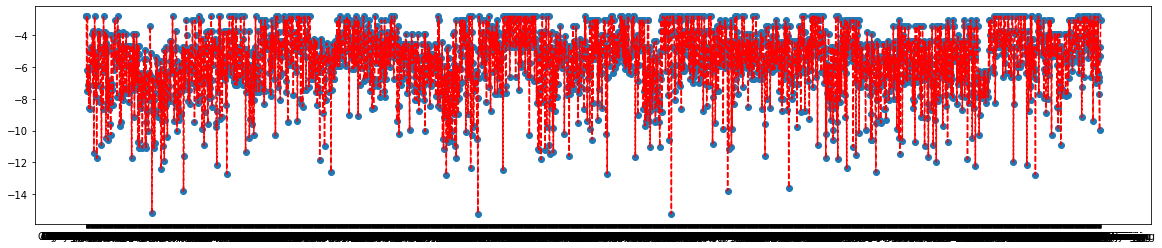

In [ ]:
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(exmp)),exmp)
#plt.xlim(-10,520)
plt.plot(exmp,"r--")
plt.show()

In [ ]:
top_5 = exmp.sort_values().head(5)
print(top_5)

County
New York, New York                           -15.242954
Suffolk, Massachusetts                       -15.218920
San Francisco, California                    -15.209478
District of Columbia, District of Columbia   -13.826869
Roulette, North Dakota                       -13.794734
dtype: float64


In [ ]:
# Part 2
t = 0
for i in Data2.columns:
  if t == 0:
    Data2 = Data2[Data2[i] != '?']
    t = 1
  else:
    Data2 = Data2[Data2[i] != '?']
    pd.to_numeric(Data2[i],errors='coerce').notnull()

df_2 = Data2.set_index(Data2.columns[0]) 
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(df_2)

# distance to each cluster center
res=pd.DataFrame(KM.transform(df_2))
res.head()

,0,1,2
0,215.546368,554.609617,101.895485
1,108.370262,655.932344,186.335226
2,410.503731,530.643663,282.291939
3,168.209200,602.378878,141.457457
4,105.075152,777.335076,315.009861


In [ ]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(df_2))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(df_2))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.set_index(df_2.index, inplace=True)
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
County,,,,,
"Shannon, South Dakota",2443.716031,1970.018443,2251.260167,1,1970.018443
"St. Louis City, Missouri",2036.147297,1332.735955,1759.249198,1,1332.735955
"Crittenden, Arkansas",1917.732820,1208.900834,1639.063836,1,1208.900834
"Petersburg City, Virginia",1644.876605,1017.910163,1394.632068,1,1017.910163
"Baltimore City, Maryland",1651.954082,918.374430,1366.737248,1,918.374430


In [ ]:
print(res['cluster'].value_counts())

0    1426
2     814
1     246
Name: cluster, dtype: int64


In [ ]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(df_2)

GaussianMixture(n_components=3, random_state=999)

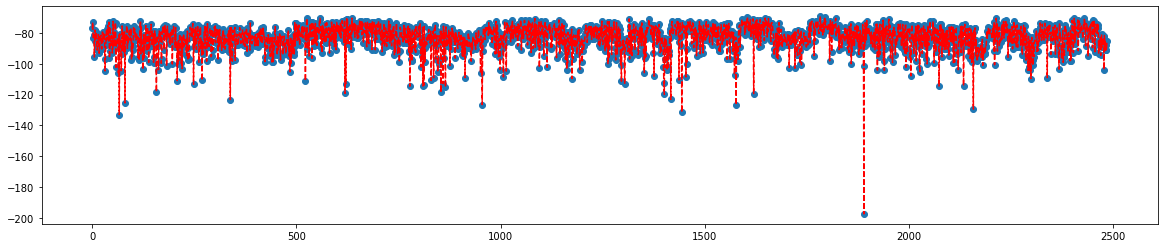

In [ ]:
# score_samples function gives the log of the probability density of each data record given its cluster.
# Note that probability densities can exceed 1 (unlike probabilities of discrete data).
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(df_2)),GM.score_samples(df_2))
plt.plot(GM.score_samples(df_2),"r--")
plt.show()

In [ ]:
GM = pd.DataFrame(GM.score_samples(df_2))
GM.set_index(df_2.index, inplace=True)
GM.sort_values(0)[:5]

,0
County,
"Shannon, South Dakota",-197.383330
"Apache, Arizona",-133.008610
"New York, New York",-131.438682
"Willacy, Texas",-129.449752
"Roulette, North Dakota",-126.664983


In [ ]:
# Also check for any very tiny clusters
print(pd.Series(GM.predict(df_2)).value_counts())

0    1194
2     649
1     643
dtype: int64


In [ ]:
# Part 3
from sklearn.neighbors import LocalOutlierFactor

#X = Data2.iloc[:,1:]
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df_2)
clf = pd.DataFrame(clf.negative_outlier_factor_)
clf.set_index(df_2.index, inplace=True)
clf.sort_values(0)[:5]

,0
County,
"Shannon, South Dakota",-4.855389
"St. Louis City, Missouri",-2.600860
"Crittenden, Arkansas",-2.378684
"Nicholas, West Virginia",-2.170029
"Petersburg City, Virginia",-2.145245


Part 4
Using all the factors to find outliers the most anomal county is same and is Shannon. This county must be very different from others. Other cities also showed few times in different models, but there are difference between each model results. May be if we improve the number head number, we can see all the counties in one model. 